In [59]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings('ignore')

In [60]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Deck_Cabin", "Side_Cabin"]
labelCols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck_Cabin", "Side_Cabin"]
numericalCols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
def preprocessingData(data):
    """
    The PassengerId and Name features don't provide any useful information that can help us predict the 
    Transported feature. The Cabin feature takes the form Deck/Num/Side. The Num part isn't too relevant 
    but the Deck and Side parts might be useful in predicting the Transported feature.
    """
    cabinSplit = data['Cabin'].str.split("/", expand=True)
    data['Deck_Cabin'] = cabinSplit[0]
    data['Side_Cabin'] = cabinSplit[2]
    data = data.drop(columns=["PassengerId", "Name", "Cabin"])
    
    #Filling the nan values in every numerical feature except Age with the mode value
    #Filling the nan values in the Age feature with the mean value
    #Filling the nan values in these categorical features with the mode value   
    #Transforming the categorical features to store int labels
    label_encoder = preprocessing.LabelEncoder()     
    for col in cols:
        if col in numericalCols:
            if col == "Age":
                data[col] = data[col].fillna(data[col].mean())
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            data[col] = label_encoder.fit_transform(data[col])
            data[col] = data[col].astype(int)
        
    return data
    

Optimization terminated successfully.
         Current function value: 0.455311
         Iterations 8


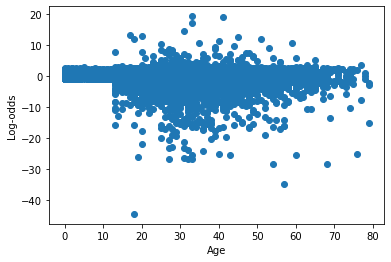

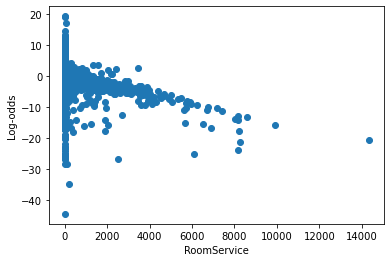

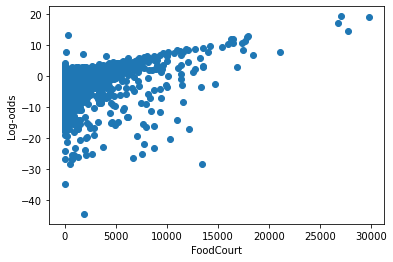

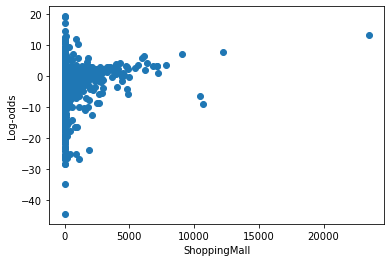

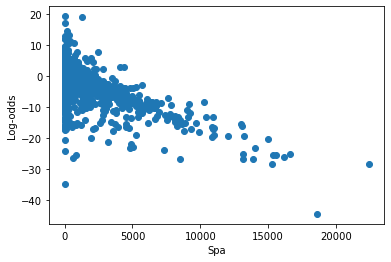

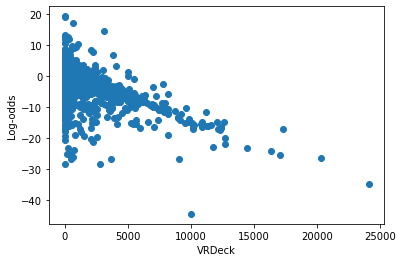

In [61]:
data = pd.read_csv("train.csv")
data = preprocessingData(data)

#Logistic Regression Assumption 1 — Appropriate Outcome Type
#Outcome must take the form of only two values: 0 and 1
data["Transported"] = data["Transported"].replace(False, 0).replace(True, 1)

#Logistic Regression Assumption 2 — Linearity of independent variables and log-odds
#The relationship between the log-odds of the outcome and each continuous independent variable is linear
y = data["Transported"]
X = data.drop(columns=["Transported"])
logit_model=sm.Logit(y,X)
result=logit_model.fit()
predicted = result.predict(X)
log_odds = np.log(predicted / (1 - predicted))

for col in numericalCols:
    plt.scatter(x=X[col], y=log_odds)
    plt.xlabel(col)
    plt.ylabel("Log-odds")
    plt.show()

"""
The Age and ShoppingMall features don't have a remotely linear relationship with the log-odds of the outcome 
as seen in the plots generated so we'll remove these features from the dataset.
"""
cols.remove("Age")
cols.remove("ShoppingMall")
numericalCols.remove("Age")
numericalCols.remove("ShoppingMall")
data = data.drop(columns=["Age", "ShoppingMall"])

In [62]:
#Logistic Regression Assumption 3 — No strongly influential outliers
#We must remove highly influential outlier data points, as they distort the outcome and accuracy of the model.
y = data["Transported"]
X = data.drop(columns=["Transported"]).drop(columns=labelCols)
logit_result = sm.GLM(y, X, family=sm.families.Binomial()).fit()
influence = logit_result.get_influence()
result = influence.summary_frame()
result = result[["cooks_d", "standard_resid"]]
result["standard_resid"] = abs(result["standard_resid"])

#Observations with Cook’s Distance > 4/N are deemed as influential
#Observations with standard deviation > 3 are deemed as outliers
cook_threshold = 4/len(data)
influential_outliers = result[(result['cooks_d'] > cook_threshold) & (result['standard_resid'] > 3)]
to_remove = list(influential_outliers.index)
data = data.drop(to_remove)

In [63]:
#Logistic Regression Assumption 4 — Absence of Multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    cols = data.columns
    i = 0
    for col in cols:
        y = data[col]
        x = data[cols.drop([col])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = 1/(1-r_squared)
        vif_df.loc[i] = [col, vif]
        i += 1
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=data.drop(['Transported'],axis=1)
#Since no Vif values exceed 5 as seen in the output generated below the assumption is satisfied by the data.
print(calculate_vif(X))

           Var       Vif
8   Deck_Cabin  4.405200
2  Destination  4.174713
9   Side_Cabin  1.931829
0   HomePlanet  1.851580
1    CryoSleep  1.747050
4  RoomService  1.265026
5    FoodCourt  1.203764
7       VRDeck  1.150538
6          Spa  1.145989
3          VIP  1.068780


In [64]:
X = data.drop(columns=["Transported"])
y = data["Transported"]

#Using Bayesian Optimization to tune the hyperparameters
max_score = (0, {})
def generateLogisticRegressionModel(c, solver):
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    return LogisticRegression(solver = solvers[solver], C=c)
    
def score(c, solver):
    solver = round(solver)
    
    def generateModel():
        return generateLogisticRegressionModel(c, solver)
        
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    model = generateModel()
    scores = cross_val_score(model, X, y, scoring="accuracy", cv=kfold)
    mean_acc = scores.mean()
    global max_score
    if mean_acc > max_score[0]:
        max_score = (mean_acc, {
            'c': c,
            'solver': solver
        })
    return mean_acc

hyperparams = {
    'c': (0.01, 100),
    'solver': (0, 2)
}
start = time.time()
bo = BayesianOptimization(score, hyperparams, random_state=1)
bo.maximize(init_points=1000, n_iter=50)
print("Best Accuracy: %f using %s" % (max_score[0], str(max_score[1])))
end = time.time()
elapsedTime = end - start
print("Elapsed Time: " + str(elapsedTime) + " seconds")

|   iter    |  target   |     c     |  solver   |
-------------------------------------------------
| 1         | 0.7924    | 41.71     | 1.441     |
| 2         | 0.7921    | 0.02144   | 0.6047    |
| 3         | 0.793     | 14.68     | 0.1847    |
| 4         | 0.7904    | 18.63     | 0.6911    |
| 5         | 0.791     | 39.68     | 1.078     |
| 6         | 0.7923    | 41.93     | 1.37      |
| 7         | 0.7929    | 20.45     | 1.756     |
| 8         | 0.7912    | 2.748     | 1.341     |
| 9         | 0.7913    | 41.74     | 1.117     |
| 10        | 0.793     | 14.05     | 0.3962    |
| 11        | 0.7928    | 80.08     | 1.937     |
| 12        | 0.7895    | 31.35     | 1.385     |
| 13        | 0.7914    | 87.64     | 1.789     |
| 14        | 0.793     | 8.514     | 0.07811   |
| 15        | 0.793     | 16.99     | 1.756     |
| 16        | 0.7922    | 9.844     | 0.8422    |
| 17        | 0.7906    | 95.79     | 1.066     |
| 18        | 0.792     | 69.19     | 0.631     |


| 100       | 0.7926    | 61.68     | 1.898     |
| 101       | 0.791     | 95.02     | 1.113     |
| 102       | 0.7927    | 91.56     | 1.283     |
| 103       | 0.7923    | 39.01     | 0.972     |
| 104       | 0.7915    | 60.44     | 1.099     |
| 105       | 0.7924    | 92.62     | 1.837     |
| 106       | 0.7928    | 39.49     | 1.927     |
| 107       | 0.793     | 17.4      | 0.2527    |
| 108       | 0.7908    | 13.52     | 1.011     |
| 109       | 0.7928    | 2.162     | 1.896     |
| 110       | 0.793     | 82.71     | 0.03004   |
| 111       | 0.7923    | 17.63     | 0.6641    |
| 112       | 0.7923    | 13.11     | 1.619     |
| 113       | 0.7926    | 34.48     | 1.88      |
| 114       | 0.7924    | 58.21     | 1.758     |
| 115       | 0.7934    | 84.47     | 1.811     |
| 116       | 0.7914    | 45.99     | 1.093     |
| 117       | 0.7913    | 79.86     | 0.5714    |
| 118       | 0.7895    | 49.03     | 1.198     |
| 119       | 0.7917    | 1.563     | 1.187     |


| 200       | 0.7905    | 51.12     | 1.082     |
| 201       | 0.7927    | 95.94     | 1.608     |
| 202       | 0.7922    | 3.242     | 1.419     |
| 203       | 0.793     | 46.51     | 1.895     |
| 204       | 0.7921    | 22.15     | 0.5341    |
| 205       | 0.7916    | 8.157     | 0.8572    |
| 206       | 0.7912    | 10.91     | 1.268     |
| 207       | 0.791     | 80.3      | 1.394     |
| 208       | 0.7923    | 76.62     | 0.6849    |
| 209       | 0.7915    | 84.59     | 0.8575    |
| 210       | 0.7934    | 82.4      | 1.253     |
| 211       | 0.793     | 14.35     | 0.1568    |
| 212       | 0.7929    | 1.843     | 0.1334    |
| 213       | 0.793     | 45.86     | 0.2267    |
| 214       | 0.7922    | 2.788     | 1.51      |
| 215       | 0.7914    | 39.49     | 1.494     |
| 216       | 0.7912    | 45.25     | 0.9002    |
| 217       | 0.7915    | 47.81     | 0.948     |
| 218       | 0.791     | 80.32     | 0.8048    |
| 219       | 0.793     | 90.47     | 0.07412   |


| 300       | 0.793     | 2.673     | 0.2218    |
| 301       | 0.7931    | 67.46     | 1.6       |
| 302       | 0.793     | 8.062     | 0.4634    |
| 303       | 0.7923    | 20.77     | 1.835     |
| 304       | 0.7912    | 71.13     | 1.108     |
| 305       | 0.7923    | 30.46     | 1.67      |
| 306       | 0.7926    | 43.54     | 1.847     |
| 307       | 0.7917    | 70.61     | 0.9561    |
| 308       | 0.7916    | 12.63     | 1.952     |
| 309       | 0.793     | 15.99     | 0.4052    |
| 310       | 0.7921    | 43.12     | 0.8084    |
| 311       | 0.7902    | 14.68     | 1.459     |
| 312       | 0.7914    | 18.88     | 1.288     |
| 313       | 0.793     | 75.43     | 0.4215    |
| 314       | 0.7919    | 60.1      | 1.498     |
| 315       | 0.791     | 63.83     | 1.194     |
| 316       | 0.7926    | 29.56     | 1.463     |
| 317       | 0.791     | 94.53     | 0.8511    |
| 318       | 0.793     | 78.22     | 0.1123    |
| 319       | 0.793     | 83.53     | 0.3845    |


| 400       | 0.7929    | 48.8      | 1.711     |
| 401       | 0.793     | 88.84     | 0.3688    |
| 402       | 0.7928    | 58.54     | 1.796     |
| 403       | 0.7922    | 44.62     | 1.844     |
| 404       | 0.79      | 27.91     | 1.218     |
| 405       | 0.793     | 68.25     | 0.4564    |
| 406       | 0.7909    | 1.387     | 0.8334    |
| 407       | 0.7904    | 93.85     | 0.6861    |
| 408       | 0.793     | 77.98     | 0.3495    |
| 409       | 0.793     | 34.2      | 0.2892    |
| 410       | 0.7919    | 71.68     | 1.399     |
| 411       | 0.7909    | 68.85     | 0.5068    |
| 412       | 0.793     | 69.24     | 0.4546    |
| 413       | 0.7914    | 42.47     | 0.7438    |
| 414       | 0.793     | 35.54     | 0.1153    |
| 415       | 0.7901    | 63.17     | 1.415     |
| 416       | 0.7928    | 61.36     | 1.297     |
| 417       | 0.793     | 17.0      | 0.2989    |
| 418       | 0.793     | 51.42     | 1.751     |
| 419       | 0.7914    | 18.4      | 0.9257    |


| 500       | 0.7926    | 32.6      | 1.549     |
| 501       | 0.7934    | 32.59     | 1.78      |
| 502       | 0.793     | 75.17     | 1.525     |
| 503       | 0.793     | 46.95     | 0.4215    |
| 504       | 0.7922    | 4.157     | 0.6437    |
| 505       | 0.7921    | 3.721     | 1.388     |
| 506       | 0.7909    | 67.04     | 0.8609    |
| 507       | 0.792     | 76.78     | 1.072     |
| 508       | 0.793     | 3.996     | 0.2696    |
| 509       | 0.7907    | 19.35     | 0.6713    |
| 510       | 0.7909    | 5.241     | 1.21      |
| 511       | 0.7897    | 51.21     | 1.235     |
| 512       | 0.7933    | 43.24     | 1.695     |
| 513       | 0.793     | 45.41     | 0.03081   |
| 514       | 0.7923    | 87.31     | 1.312     |
| 515       | 0.7924    | 82.3      | 1.904     |
| 516       | 0.793     | 5.101     | 0.4701    |
| 517       | 0.7919    | 6.344     | 0.8433    |
| 518       | 0.793     | 86.38     | 0.1632    |
| 519       | 0.793     | 47.32     | 0.2511    |


| 600       | 0.792     | 63.54     | 1.696     |
| 601       | 0.7937    | 82.19     | 1.256     |
| 602       | 0.7908    | 95.63     | 1.18      |
| 603       | 0.7916    | 19.79     | 0.8587    |
| 604       | 0.793     | 33.68     | 1.984     |
| 605       | 0.7928    | 38.03     | 1.985     |
| 606       | 0.793     | 51.89     | 0.3446    |
| 607       | 0.7917    | 7.467     | 0.7406    |
| 608       | 0.7928    | 12.35     | 1.269     |
| 609       | 0.7928    | 41.4      | 1.982     |
| 610       | 0.793     | 93.0      | 0.2985    |
| 611       | 0.7921    | 39.49     | 0.9232    |
| 612       | 0.7924    | 56.1      | 1.561     |
| 613       | 0.7906    | 48.72     | 0.84      |
| 614       | 0.7921    | 26.21     | 1.822     |
| 615       | 0.7917    | 2.237     | 1.642     |
| 616       | 0.7919    | 18.85     | 1.372     |
| 617       | 0.7926    | 35.53     | 1.948     |
| 618       | 0.793     | 12.29     | 0.3751    |
| 619       | 0.7919    | 88.95     | 1.167     |


| 700       | 0.7926    | 95.19     | 1.776     |
| 701       | 0.7916    | 51.81     | 0.7455    |
| 702       | 0.7908    | 71.04     | 0.9113    |
| 703       | 0.7927    | 60.53     | 1.981     |
| 704       | 0.7921    | 77.39     | 0.6686    |
| 705       | 0.793     | 8.909     | 0.3698    |
| 706       | 0.792     | 52.69     | 0.8342    |
| 707       | 0.7921    | 80.07     | 1.866     |
| 708       | 0.7917    | 17.79     | 1.72      |
| 709       | 0.7921    | 95.74     | 1.919     |
| 710       | 0.793     | 3.796     | 0.1152    |
| 711       | 0.7923    | 0.5897    | 0.6254    |
| 712       | 0.7916    | 5.579     | 0.5877    |
| 713       | 0.7923    | 35.61     | 1.907     |
| 714       | 0.7922    | 47.7      | 0.5565    |
| 715       | 0.7919    | 50.31     | 1.287     |
| 716       | 0.7921    | 11.13     | 1.516     |
| 717       | 0.7931    | 85.2      | 1.688     |
| 718       | 0.7909    | 89.05     | 0.7637    |
| 719       | 0.793     | 44.39     | 0.2032    |


| 800       | 0.7933    | 76.62     | 1.882     |
| 801       | 0.7916    | 0.1133    | 0.9522    |
| 802       | 0.7933    | 65.71     | 1.687     |
| 803       | 0.7922    | 18.38     | 1.712     |
| 804       | 0.7921    | 36.44     | 1.785     |
| 805       | 0.793     | 2.781     | 0.1708    |
| 806       | 0.7905    | 98.14     | 1.219     |
| 807       | 0.793     | 41.77     | 0.3384    |
| 808       | 0.793     | 64.99     | 0.07395   |
| 809       | 0.7909    | 31.17     | 0.647     |
| 810       | 0.7921    | 60.75     | 1.302     |
| 811       | 0.7924    | 84.61     | 1.855     |
| 812       | 0.792     | 66.05     | 1.156     |
| 813       | 0.7922    | 39.88     | 1.933     |
| 814       | 0.7922    | 15.42     | 1.79      |
| 815       | 0.7914    | 31.11     | 1.097     |
| 816       | 0.793     | 68.21     | 0.4729    |
| 817       | 0.7922    | 16.78     | 1.017     |
| 818       | 0.7912    | 79.19     | 1.385     |
| 819       | 0.7916    | 11.91     | 1.801     |


| 900       | 0.7919    | 77.09     | 0.8414    |
| 901       | 0.7921    | 97.79     | 0.5015    |
| 902       | 0.7927    | 33.37     | 1.908     |
| 903       | 0.7926    | 80.87     | 1.801     |
| 904       | 0.791     | 1.169     | 0.7595    |
| 905       | 0.7907    | 23.56     | 0.5919    |
| 906       | 0.7921    | 73.8      | 1.448     |
| 907       | 0.791     | 46.19     | 0.7305    |
| 908       | 0.7912    | 58.47     | 1.067     |
| 909       | 0.7913    | 55.06     | 1.231     |
| 910       | 0.7921    | 39.57     | 1.543     |
| 911       | 0.7914    | 25.13     | 1.312     |
| 912       | 0.793     | 96.04     | 0.00711   |
| 913       | 0.793     | 72.34     | 0.218     |
| 914       | 0.7906    | 54.38     | 1.254     |
| 915       | 0.7929    | 24.3      | 1.828     |
| 916       | 0.793     | 62.24     | 0.4634    |
| 917       | 0.793     | 77.02     | 0.211     |
| 918       | 0.793     | 55.53     | 0.1899    |
| 919       | 0.7916    | 58.1      | 0.506     |


| 1000      | 0.7922    | 3.109     | 1.893     |
| 1001      | 0.7927    | 68.65     | 1.67      |
| 1002      | 0.7937    | 60.55     | 1.541     |
| 1003      | 0.793     | 86.2      | 0.03653   |
| 1004      | 0.792     | 2.303     | 1.057     |
| 1005      | 0.7924    | 81.68     | 1.739     |
| 1006      | 0.7921    | 88.77     | 0.8944    |
| 1007      | 0.7922    | 60.57     | 1.54      |
| 1008      | 0.7929    | 23.6      | 1.877     |
| 1009      | 0.7901    | 55.32     | 1.404     |
| 1010      | 0.7908    | 14.85     | 0.8134    |
| 1011      | 0.7927    | 48.46     | 1.701     |
| 1012      | 0.7927    | 50.0      | 1.569     |
| 1013      | 0.7916    | 50.0      | 1.535     |
| 1014      | 0.793     | 25.46     | 1.778     |
| 1015      | 0.7901    | 16.82     | 1.368     |
| 1016      | 0.7915    | 39.55     | 1.896     |
| 1017      | 0.7928    | 28.49     | 1.818     |
| 1018      | 0.7929    | 51.72     | 1.845     |
| 1019      | 0.7921    | 21.96     | 1.666     |


In [66]:
"""
According to the output generated above, the Logistic Regression algorithm displayed the best performance 
when using these hyperparameter values: {'c': 49.998237786209, 'solver': 2}.
"""

hyperparams = max_score[1]


"""
Precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
Recall is intuitively the ability of the classifier to find all the positive samples.
F1-score can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score 
reaches its best value at 1 and its worst score at 0.
"""
model = generateLogisticRegressionModel(hyperparams['c'], hyperparams['solver'])
model.fit(X, y)
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.79      4310
         1.0       0.78      0.81      0.80      4314

    accuracy                           0.79      8624
   macro avg       0.79      0.79      0.79      8624
weighted avg       0.79      0.79      0.79      8624



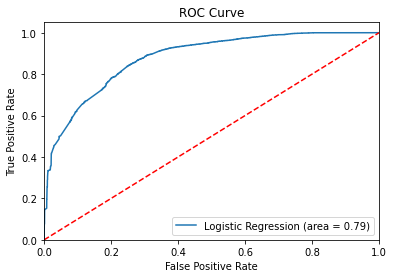

In [67]:
"""
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away 
from that line as possible
"""
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [68]:
#Final predictions on the test set to provide for submission
test_data = pd.read_csv("test.csv")
passenger_ids = test_data["PassengerId"]
test_data = preprocessingData(test_data)
test_data = test_data.drop(columns=["Age", "ShoppingMall"])

model = generateLogisticRegressionModel(hyperparams['c'], hyperparams['solver'])
model.fit(X, y)
y_pred = model.predict(test_data)

final_submission = pd.DataFrame()
final_submission["PassengerId"] = passenger_ids
final_submission["Transported"] = y_pred
final_submission["Transported"] = final_submission["Transported"].replace(0, False).replace(1, True)
final_submission.to_csv('LogisticRegressionSubmission.csv', index=False)
#Final Submission Produced an accuracy of 0.78372 on the test set